## Máster en Inteligencia Artificial Avanzada y Aplicada, IA³
**Alumno:** *Óscar Mateos López*


# Climate Change and Sea Ice Extent

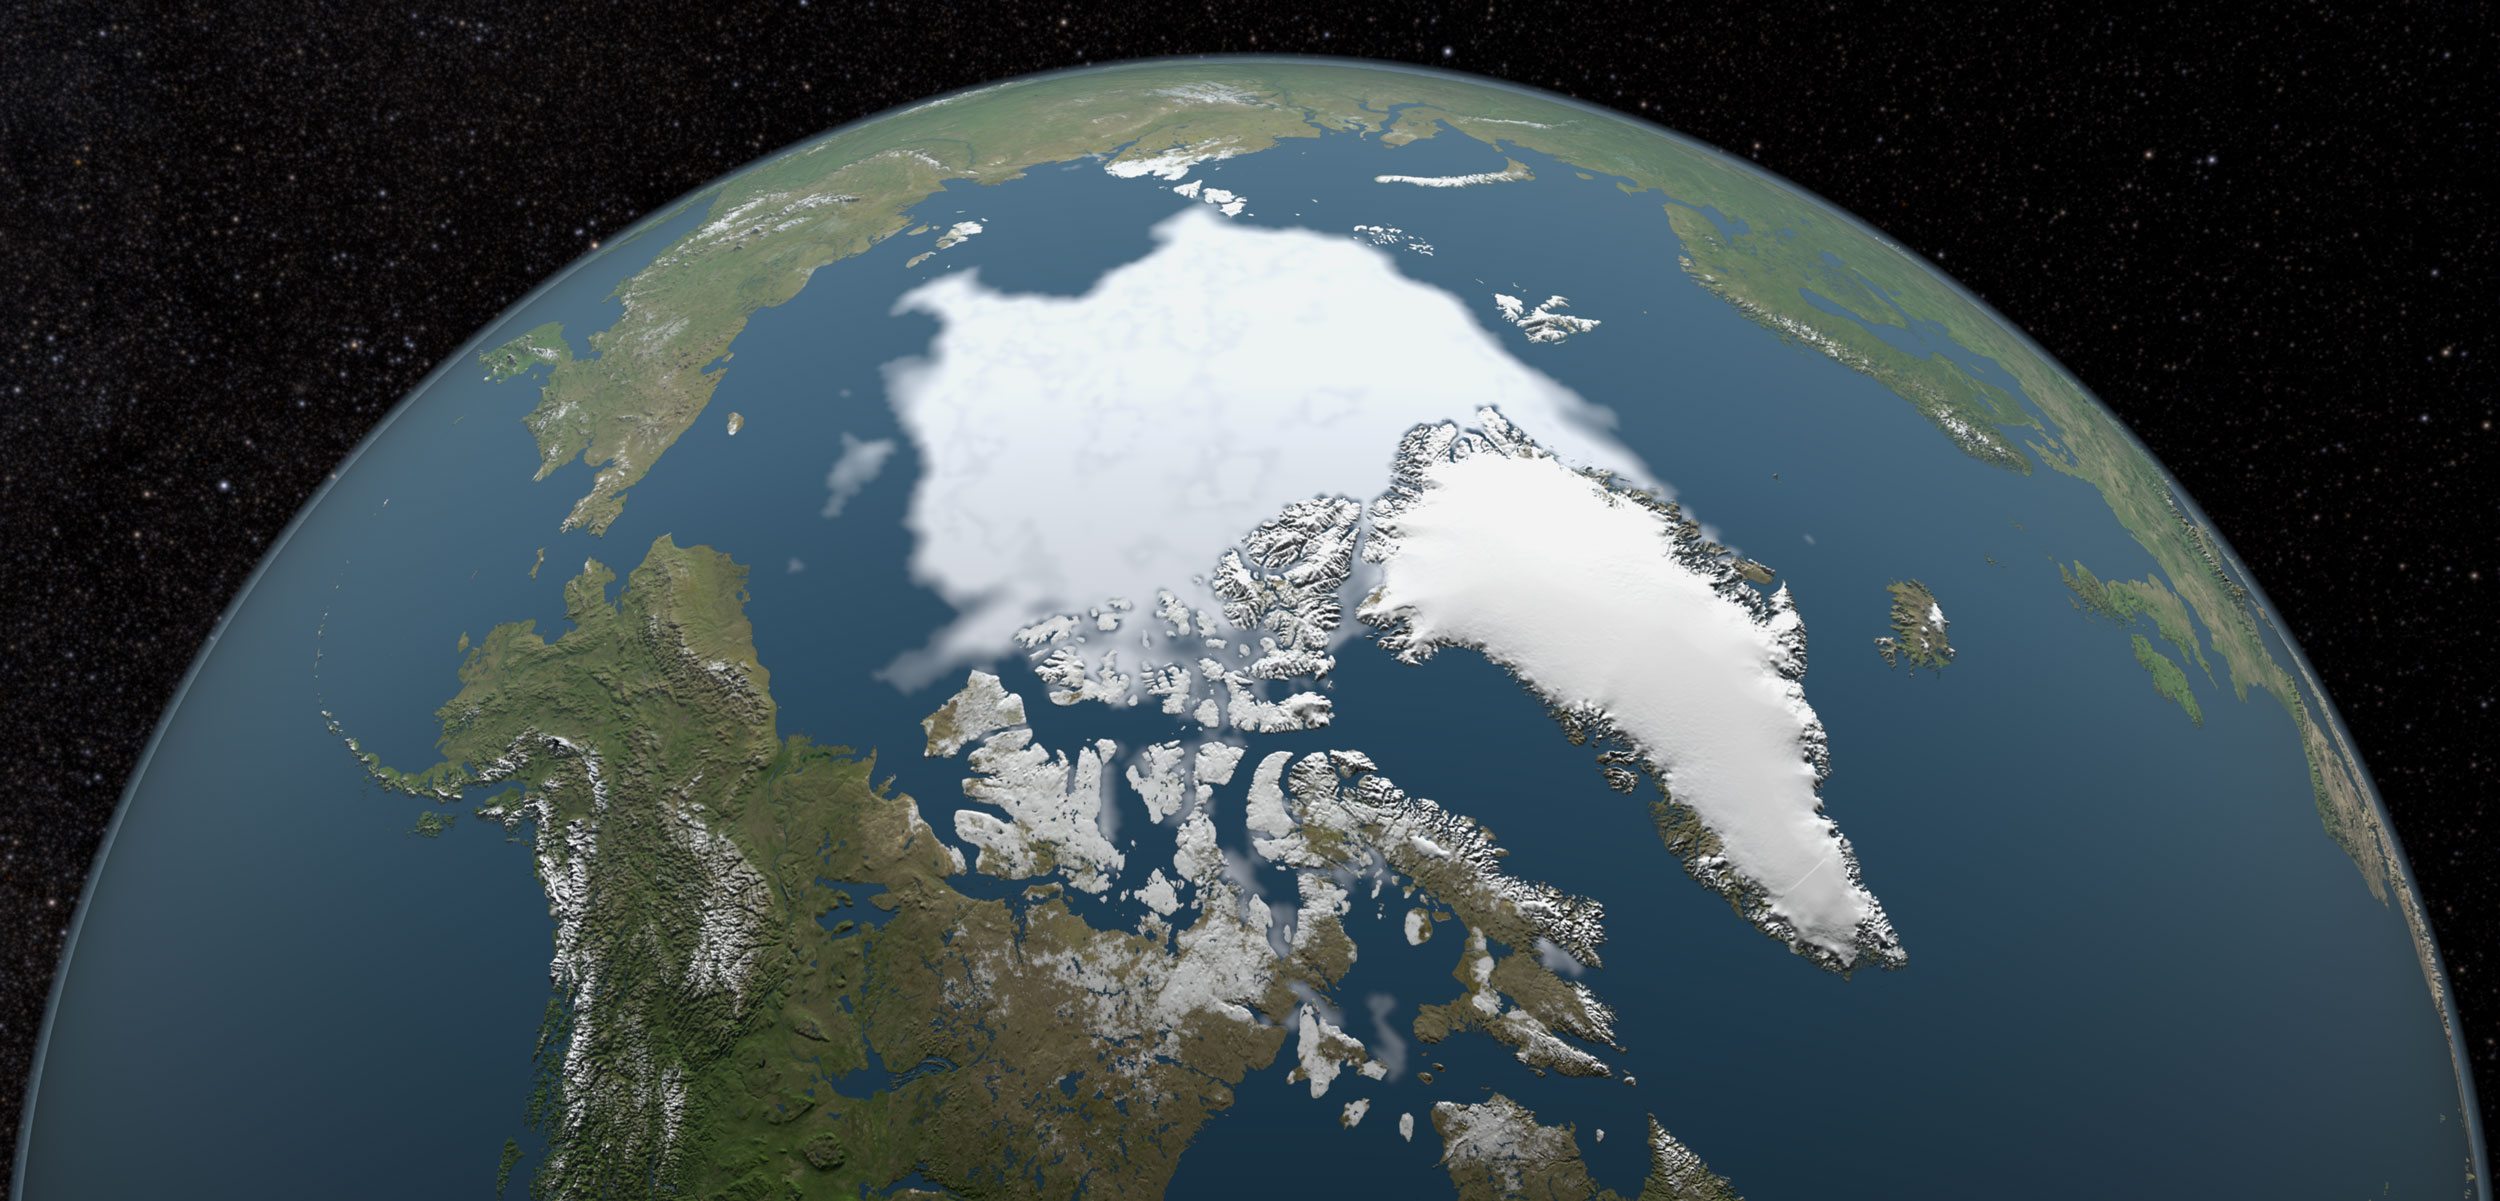

We want to answer the question: Has there been a decrease in the amount of ice in the last years?

For that we will use the sea ice extent measurements (in millions of square km) from the [National Snow & Ice Data Center](https://nsidc.org).

We perform the following processing steps:
1. Read and clean the data.
2. Normalize the Sea Ice Extent (SIE) data and visualize its temporal trend.
3. Compute the SIE temporal trend as a simple linear regression (OLS) and quantitatively evaluate it.
4. Estimate the sea ice extent for 2025.

## 1. Read and clean the data.
Load the monthly sea ice extent (SIE) monthly data provided in the file 'SeaIce.txt'. Note variables ``extent`` (SIE) and ``area`` should be greater or equal than zero. Detect possible outliers and clean the data.  

In [757]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import date
from matplotlib import pyplot
import seaborn as sns
from scipy.stats import pearsonr
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn import metrics

### Initial inspection & EDA (Exploratory data analysis)

In [758]:
sea_ice = pd.read_csv('SeaIce.txt',  delim_whitespace=True)
sea_ice.head()

,year,mo,data_type,region,extent,area
0,1979,1,Goddard,N,15.54,12.33
1,1980,1,Goddard,N,14.96,11.85
2,1981,1,Goddard,N,15.03,11.82
3,1982,1,Goddard,N,15.26,12.11
4,1983,1,Goddard,N,15.10,11.92


In [759]:
# Check dataset's rows and columns (shape)
sea_ice.shape

(424, 6)

### Check out of range or invalid records

#### Extent

In [760]:
sea_ice[sea_ice['extent'] < 0] 

,year,mo,data_type,region,extent,area
9,1988,1,-9999,N,-9999.0,-9999.0
397,1987,12,-9999,N,-9999.0,-9999.0


#### Area

In [761]:
sea_ice[sea_ice['area'] < 0]

,year,mo,data_type,region,extent,area
9,1988,1,-9999,N,-9999.0,-9999.0
397,1987,12,-9999,N,-9999.0,-9999.0


In [762]:
#Remove them both
sea_ice.drop(sea_ice[sea_ice['area'] < 0].index, inplace=True)
sea_ice.shape

(422, 6)

### Some other checks: Columns with constant values
These columns, if exists, won't provide any additional information, so should be removed in order to simplify the dataset.

#### Data Type

In [763]:
sea_ice['data_type'].value_counts()

Goddard    409
NRTSI-G     13
Name: data_type, dtype: int64

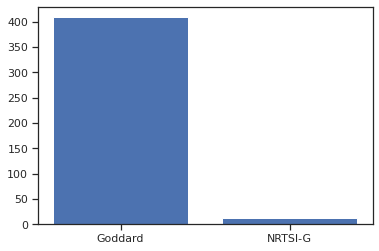

In [764]:
# This column can be kept as its not constant
data_type_counts = dict(sea_ice['data_type'].value_counts())
plt.bar(list(data_type_counts.keys()), data_type_counts.values())
plt.show()

#### Region

In [765]:
sea_ice['region'].value_counts()

N    422
Name: region, dtype: int64

In [766]:
sea_ice[sea_ice['region'] != 'N']

,year,mo,data_type,region,extent,area


As all of the observations have the same value (422) this column doesnt provide any information and will be removed.

In [767]:
# Drop region column
sea_ice.drop(['region'], axis=1, inplace=True)
sea_ice

,year,mo,data_type,extent,area
0,1979,1,Goddard,15.54,12.33
1,1980,1,Goddard,14.96,11.85
2,1981,1,Goddard,15.03,11.82
3,1982,1,Goddard,15.26,12.11
4,1983,1,Goddard,15.10,11.92
...,...,...,...,...,...
419,2009,12,Goddard,12.51,10.25
420,2010,12,Goddard,12.02,10.08
421,2011,12,Goddard,12.40,10.28
422,2012,12,Goddard,12.20,10.11


### Outliers
The outliers will be detected from the Boxplot graphs, so all the points out of **±1.5 x IQR** will be considered as outliers as follows:

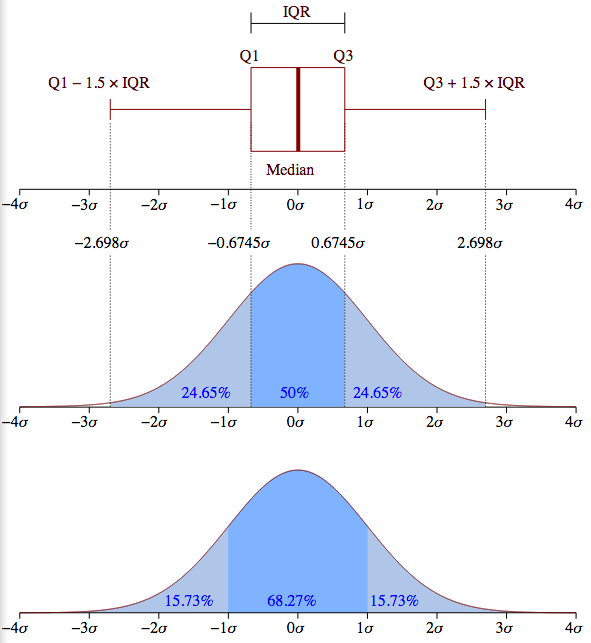

We will get them by the use of the ``boxplot`` procedure: the function itself will store the ouliers when computes the boxplot, storing them at ``fliers``. If any values are stored there, then we will generate an outlier-free dataset by dropping them from the original dataset by the reference of those values.

## Let's see the variables

#### Year

In [768]:
# Summary of statistics
sea_ice['year'].describe()

count     422.000000
mean     1996.040284
std        10.222038
min      1978.000000
25%      1987.000000
50%      1996.000000
75%      2005.000000
max      2014.000000
Name: year, dtype: float64

Analysing the statistics there are monthly observations from 1978-2014.

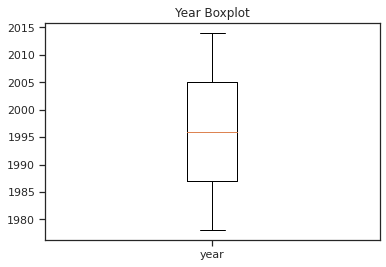

In [769]:
# Boxplot, here actually is not needed based on the details above, just to check if the observations were centered over the years
fig, ax = plt.subplots()
ax.set_title('Year Boxplot')
bp = ax.boxplot(sea_ice['year'], labels=['year'])

#### Month
This column corresponds with the month of each observation

In [770]:
# Summary of statistics
sea_ice['mo'].describe()

count    422.000000
mean       6.500000
std        3.461872
min        1.000000
25%        3.250000
50%        6.500000
75%        9.750000
max       12.000000
Name: mo, dtype: float64

Analysing the statistics there are monthly observations from 1978-2014.

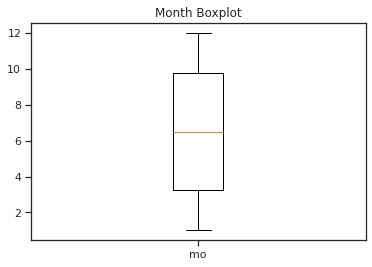

In [771]:
# Boxplot, again here we don't need to check the outliers as the max and min values are within [1, 12], but we can check that the data is centered
fig, ax = plt.subplots()
ax.set_title('Month Boxplot')
bp = ax.boxplot(sea_ice['mo'], labels=['mo'])

---
**NOTE**

These two variables will be packed as a single date column *Year-Month* after the ouliers' analysis. 
<br>Using the date or the year/month sepparately could bring different insights.


---

#### Extent
The out-of-range values has been dropped at a prior point, but still more valid extreme values could persist

In [772]:
# Summary of statistics
sea_ice['extent'].describe()

count    422.000000
mean      11.777583
std        3.120722
min        3.630000
25%        9.360000
50%       12.395000
75%       14.560000
max       16.450000
Name: extent, dtype: float64

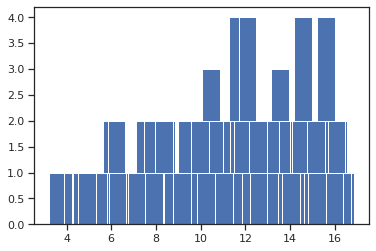

In [773]:
# Barplot
extent_counts = dict(sea_ice['extent'].value_counts())
plt.bar(list(extent_counts.keys()), extent_counts.values())
plt.show()

A normalization step could be placed for extent.

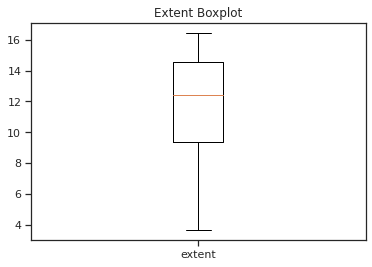

In [774]:
# Boxplot
fig, ax = plt.subplots()
ax.set_title('Extent Boxplot')
bp = ax.boxplot(sea_ice['extent'], labels=['extent'])

There are no outliers for extent.

#### Area
The out-of-range values has been dropped at a prior point, but still more valid extreme values could persist

In [775]:
# Summary of statistics
sea_ice['area'].describe()

count    422.000000
mean       9.287796
std        3.180044
min        2.150000
25%        6.382500
50%        9.990000
75%       12.227500
max       13.840000
Name: area, dtype: float64

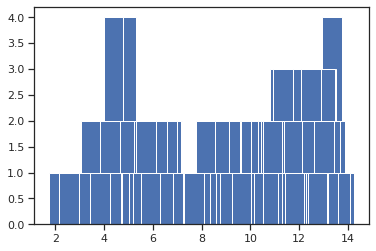

In [776]:
# Barplot
area_counts = dict(sea_ice['area'].value_counts())
plt.bar(list(area_counts.keys()), area_counts.values())
plt.show()

A normalization step could be placed for area.

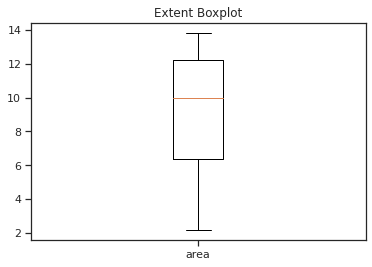

In [777]:
# Boxplot
fig, ax = plt.subplots()
ax.set_title('Extent Boxplot')
bp = ax.boxplot(sea_ice['area'], labels=['area'])

There are no outliers for area.

### Parse dates from Year and Month columns 
Both columns ``year`` and ``mo`` will be combined into a single Date (***``year_month``***) column as the 1<sup>st</sup> day of the month for each observation.

In [778]:
# Parse dates
year_month = []
for y, m in zip(sea_ice['year'], sea_ice['mo']):
    year_month.append(date(y, m, 1))
    
sea_ice['year_month'] = year_month
sea_ice

,year,mo,data_type,extent,area,year_month
0,1979,1,Goddard,15.54,12.33,1979-01-01
1,1980,1,Goddard,14.96,11.85,1980-01-01
2,1981,1,Goddard,15.03,11.82,1981-01-01
3,1982,1,Goddard,15.26,12.11,1982-01-01
4,1983,1,Goddard,15.10,11.92,1983-01-01
...,...,...,...,...,...,...
419,2009,12,Goddard,12.51,10.25,2009-12-01
420,2010,12,Goddard,12.02,10.08,2010-12-01
421,2011,12,Goddard,12.40,10.28,2011-12-01
422,2012,12,Goddard,12.20,10.11,2012-12-01


#### Scatter Matrix

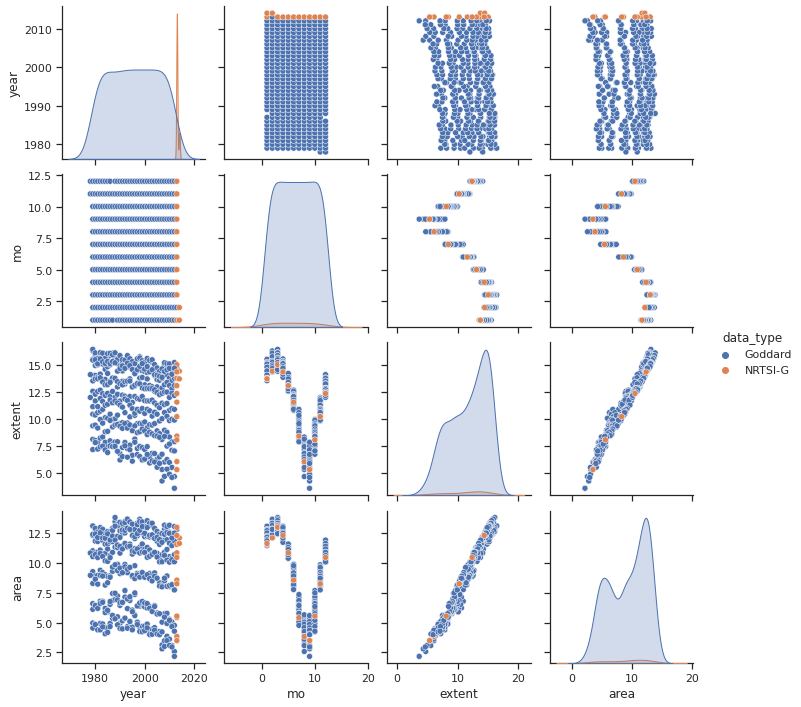

In [779]:
sns.set_theme(style='ticks')
scat_ma = sns.pairplot(sea_ice, hue='data_type')

Obvious linear relation between ``area`` and ``extent``, as they both are similar measures of the ice. Each of them pairwised with ``mo`` shows the change given by the seasons over the observed years.

### Plot the series for both variables

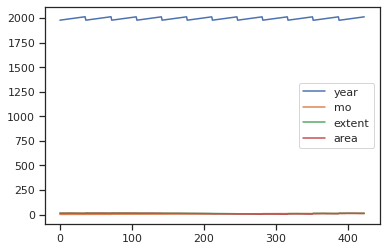

In [780]:
sea_ice.plot()
pyplot.show()

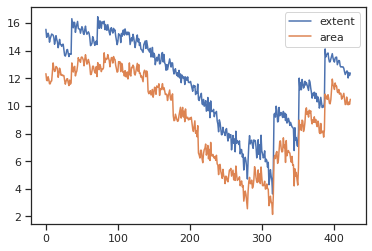

In [781]:
# Using the dataset with the parsed dates brings clearer results
sea_ice_date[['year_month', 'extent', 'area']].plot()
pyplot.show()

## 2. Normalize the SIE data and visualize its temporal trend.

Visualize there is a monthly dependence of SIE, explore the linear relationship using ``lmplot``.
Compute the mean and variance of SIE for each month.

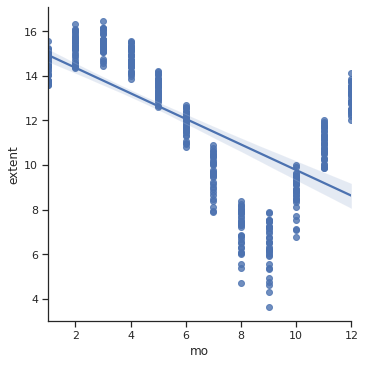

In [782]:
# Linear relationship between ice extent and months
# We can perceive some seasonal fluctuation: higher extent on winter while lower on summer
lr = sns.lmplot( x='mo', y='extent' , data=sea_ice)

In [783]:
# Compute the mean and variance of SIE for each month
monthly_slices = []
columns = ['mo', 'monthly_mean_extent', 'monthly_var_extent']

for i in range(sea_ice['mo'].min(),sea_ice['mo'].max()+1):
  monthly_slice = sea_ice.loc[sea_ice['mo'] == i, ['extent']]
  monthly_mean = monthly_slice.mean()[0]
  monthly_var = monthly_slice.var()[0]

  monthly_slices.append((i, monthly_mean, monthly_var))

df = pd.DataFrame.from_records(monthly_slices, columns=columns)
df

,mo,monthly_mean_extent,monthly_var_extent
0,1,14.479429,0.304906
1,2,15.298889,0.295804
2,3,15.491714,0.237209
3,4,14.766000,0.215378
4,5,13.396000,0.189901
5,6,11.860000,0.247918
6,7,9.601143,0.679175
7,8,7.122286,0.824577
8,9,6.404857,1.143902
9,10,8.809143,0.630361



Join both dataframes by ``mo`` (key) field to the master ~~*table*~~ dataframe

In [784]:
# Join both dataframes by month
sea_ice = sea_ice.join(df.set_index('mo'), on='mo')
sea_ice

,year,mo,data_type,extent,area,year_month,monthly_mean_extent,monthly_var_extent
0,1979,1,Goddard,15.54,12.33,1979-01-01,14.479429,0.304906
1,1980,1,Goddard,14.96,11.85,1980-01-01,14.479429,0.304906
2,1981,1,Goddard,15.03,11.82,1981-01-01,14.479429,0.304906
3,1982,1,Goddard,15.26,12.11,1982-01-01,14.479429,0.304906
4,1983,1,Goddard,15.10,11.92,1983-01-01,14.479429,0.304906
...,...,...,...,...,...,...,...,...
419,2009,12,Goddard,12.51,10.25,2009-12-01,13.059429,0.284870
420,2010,12,Goddard,12.02,10.08,2010-12-01,13.059429,0.284870
421,2011,12,Goddard,12.40,10.28,2011-12-01,13.059429,0.284870
422,2012,12,Goddard,12.20,10.11,2012-12-01,13.059429,0.284870


Normalize the SIE data: substract the monthly mean and then convert to percent difference by dividing by the monthly mean and then multiplying by 100. Use the normalized SIE for the rest of the exercise.

In [785]:
# Normalization of extent
sea_ice['norm_extent'] = ((sea_ice['extent'] - sea_ice['monthly_mean_extent']) / sea_ice['monthly_mean_extent'].mean() * 100)
sea_ice

,year,mo,data_type,extent,area,year_month,monthly_mean_extent,monthly_var_extent,norm_extent
0,1979,1,Goddard,15.54,12.33,1979-01-01,14.479429,0.304906,9.005001
1,1980,1,Goddard,14.96,11.85,1980-01-01,14.479429,0.304906,4.080391
2,1981,1,Goddard,15.03,11.82,1981-01-01,14.479429,0.304906,4.674740
3,1982,1,Goddard,15.26,12.11,1982-01-01,14.479429,0.304906,6.627603
4,1983,1,Goddard,15.10,11.92,1983-01-01,14.479429,0.304906,5.269090
...,...,...,...,...,...,...,...,...,...
419,2009,12,Goddard,12.51,10.25,2009-12-01,13.059429,0.284870,-4.665037
420,2010,12,Goddard,12.02,10.08,2010-12-01,13.059429,0.284870,-8.825483
421,2011,12,Goddard,12.40,10.28,2011-12-01,13.059429,0.284870,-5.599014
422,2012,12,Goddard,12.20,10.11,2012-12-01,13.059429,0.284870,-7.297156


Visualize the trend of SIE per year considering:1) all months, 2) January, 3) August

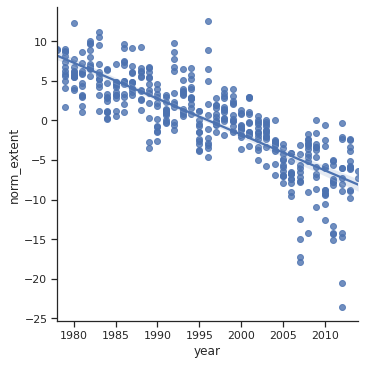

In [786]:
#All months
all_months_trend = sns.lmplot( x='year', y='norm_extent' , data=sea_ice)

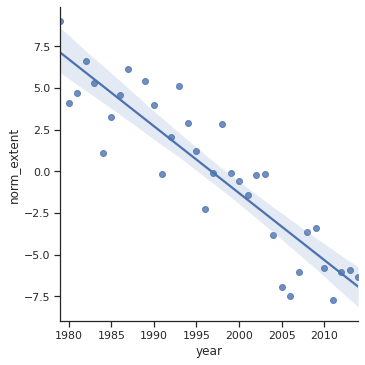

In [787]:
#January
january_trend = sns.lmplot( x='year', y='norm_extent' , data=sea_ice.loc[sea_ice['mo'] == 1, ['year', 'norm_extent']])

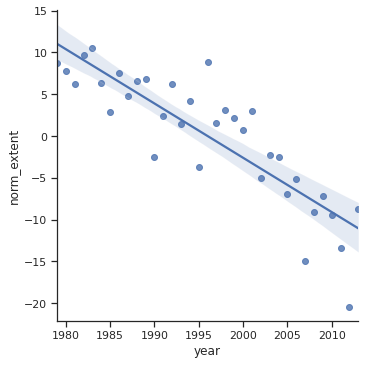

In [788]:
#August
august_trend = sns.lmplot( x='year', y='norm_extent' , data=sea_ice.loc[sea_ice['mo'] == 8, ['year', 'norm_extent']])

Calculate the Pearson correlation coefficient and the p-value for testing non-correlation of the SIE temporal trend (consider all months). Is it significant?

#### Pearson correlation
This is a measure of the strength of the linear between year and the normalized extent, as we can see below, there is a strong negative rerlationship among them.

In [789]:
#Pearson correlation coefficient
pearson_corr = sea_ice[['year', 'norm_extent']].corr(method='pearson')
pearson_corr

,year,norm_extent
year,1.00000,-0.81835
norm_extent,-0.81835,1.00000


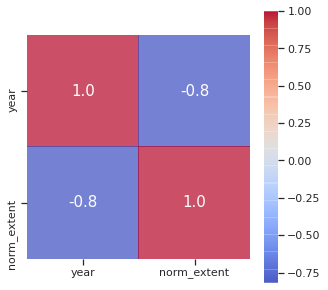

In [790]:
# Heatmap representation
plt.figure(figsize=(5,5))
sns.heatmap(sea_ice[['year', 'norm_extent']].corr(method='pearson'),cbar=True,square=True,annot=True,fmt='.1f',annot_kws={'size': 15},alpha=0.7,cmap= 'coolwarm')
plt.show()

To get the p-value we have to use the method ``pearsonr`` from ``scipy.stats``.
<br>Our hypothesis formulation is as follows:
- **H<sub>0</sub>:** There is **not difference** on the ice extents over the years **(null hypothesis)**.
- **H<sub>1</sub>:** There is **difference** on the ice extents over the years **(alternative hypothesis)**.
<br>

As this value is very low (close to 0) we can conclude there is enough significance from the test and we can accept the alternative hypothesis.

In [791]:
#p-value
pearsonr(sea_ice['year'], sea_ice['norm_extent'])[1]

4.449231816871353e-103

### 3. Compute the trend as a simple linear regression (OLS) and quantitatively evaluate it.

Provide the estimated parameters for the linear regression. 
Evaluate the quality of fit quantitatively and graphically.

#### Quantitatively
Let's build a linear model with the ``statsmodels`` package and evaluate **quantitatively** the predictions

- We take the **single response variable y as the ice extent** ``norm_extent`` and store it separately. 
- We also add a constant term to our predictor X ``year`` so that we fit the intercept of our linear model.

In [792]:
# Linear model
y = sea_ice['norm_extent']  # response
X = sea_ice['year']  # predictor
X = sm.add_constant(X)  # Adds a constant term to the predictor
X.head()

,const,year
0,1.0,1979
1,1.0,1980
2,1.0,1981
3,1.0,1982
4,1.0,1983


**First try:**
Only use the year as predictor, we try to predict the extent by the use of its normalized value. 

As you can check below, this try results on a relatively high measured mean squared errors (MSE) and its R<sup>2</sup> is around 0.69, we will try to improve this result by the addition of more predictors.


In [793]:
# Ordinary Least Squares
est = sm.OLS(y, X)
est = est.fit()
est.predict()
print(est.params)
print('MSE: ',est.mse_total)
print('R_squared: ',est.rsquared)

const    903.221583
year      -0.452507
dtype: float64
MSE:  31.948225258475603
R_squared:  0.6696968386888769


**Second try:**
Use the year and the month as predictors, we try to predict the extent by the use of its normalized value. 

As you can check below, this increase on the predictors won't improve the mean squared errors (MSE) and its R<sup>2</sup> gets barely improved, we will try to improve this result by switching the response variable with the original ``extent`` observed values without normalization.


In [794]:
# Linear model
y = sea_ice['norm_extent']  # response
X = sea_ice[['year', 'mo']]  # predictor
X = sm.add_constant(X)  # Adds a constant term to the predictor
est = sm.OLS(y, X)
est = est.fit()
est.predict()
print(est.params)
print('MSE: ',est.mse_total)
print('R_squared: ',est.rsquared)

const    903.940052
year      -0.452763
mo        -0.031811
dtype: float64
MSE:  31.948225258475603
R_squared:  0.6700762370161878


**Third try:**
Use the year, the month and... why not? the area as predictors, we try to predict the extent by the use of its observed values (non-normalized). 


As you can check below, this change will improve the mean squared errors (MSE) down to 9.73 (so less than a third from the initial and second tries) and its R<sup>2</sup> gets highly improved until reaching a 0.98 value, really much closer to 1.0. <br>Notice also the change on the weights for the predictors. 

**Please pay attention to the note below!**

In [795]:
# Linear model
y = sea_ice['extent']  # response
X = sea_ice[['year', 'mo', 'area']]  # predictor
X = sm.add_constant(X)  # Adds a constant term to the predictor
est = sm.OLS(y, X)
est = est.fit()
est.predict()
print(est.params)
print('MSE: ',est.mse_total)
print('R_squared: ',est.rsquared)

const    65.664588
year     -0.031163
mo       -0.046981
area      0.928244
dtype: float64
MSE:  9.738906257950491
R_squared:  0.9817193671503633


---
**NOTE**

But this quite great improvement shouldn't be taken as acceptable (*that was too good to be true*), as we are using the area, which is a very similar (or a derived) measure from the extent. 

**So we will assume we can't include that and finally will keep the set up from the second try.**


---

#### Graphically
As we have to choose only one predictor for getting the regression graph, we will use the model from the first try, including the normalized extent as the response.

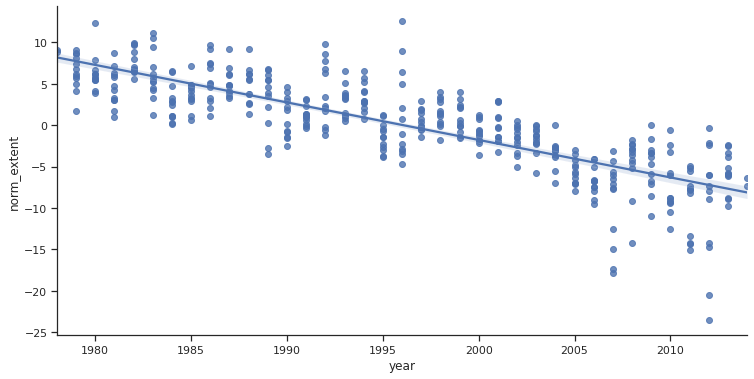

In [796]:
# Graphically
import warnings
warnings.filterwarnings("ignore")

sns.lmplot("year", "norm_extent", sea_ice[['year', 'norm_extent']] , height=5.2,aspect=2);

This plot has two main components. 

+ The first is a scatterplot, showing the observed datapoints (normalized extents). 
+ The second is a regression line, showing the estimated linear model relating the two variables. Because the regression line is only an estimate, it is plotted with a 95% confidence band to give an impression of the certainty in the model.

We can observe that there is an evidence regarding the decreasing ice extent over the last 36 years.

### 4. Estimate the sea ice extent for January 2025

 Is there a negative trend in the evolution of sea ice extent over recent years? 

For this specific prediction value for a given date we will use the model from the **second try** from the prrevious exercise (3) as it included the **year** and **month** as the predictors. This variables are our available input data for getting the future value (``mo = 1`` and ``year = 2025``).

In [797]:
# Linear model
y = sea_ice['norm_extent']  # response
X = sea_ice[['year', 'mo']]  # predictor
X = sm.add_constant(X)  # Adds a constant term to the predictor
est = sm.OLS(y, X)
est = est.fit()

# Form the record to predict
Xpred = pd.DataFrame.from_dict({'const':[1.0], 'year': [2025], 'mo': [1]})
y_hat = est.predict(Xpred)
print("Ice extent for January 2025:", y_hat)

Ice extent for January 2025: 0   -12.936926
dtype: float64


The predicted point in **red**

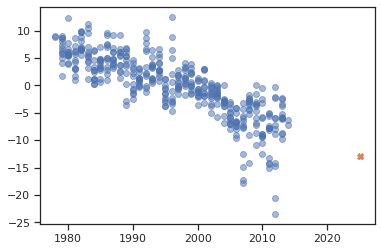

In [798]:
# Plot the prediction with the observed extents
plt.figure()
plt.plot(sea_ice[['year']], sea_ice[['norm_extent']], 'o', alpha=0.5)
plt.plot([[2025]], y_hat, 'X')

**Prediction for January 2025:**
As we used the normalized values, we are getting a negative value for the prediction, which **indicates the negative trend**. In order to get the actual value, a de-normalization step is required which is the inverse operation to the normalization performed.

In [801]:
# De-normalization
y_hat_denorm = ( y_hat * sea_ice['monthly_mean_extent'].mean() /100) + sea_ice.loc[sea_ice['mo'] == 1, ['extent']].mean()[0]
print("Ice extent for January 2025 after de-normalization:", float(y_hat_denorm))

Ice extent for January 2025 after de-normalization: 12.955771351482273
